# Mean Shift clustering with JAX
> Learn about the Mean Shift clustering algorithm and how to implement it with JAX

- toc: false
- badges: true
- comments: true
- author: dzlab
- categories: [jax, clustering]

Clustering techniques are unsupervised learning algorithms that try to group unlabelled data that look similar into groups (also called clusters). In this article, we will have a detailed look at one of those techniques and then implement it in [JAX](https://github.com/google/jax).

![](https://upload.wikimedia.org/wikipedia/commons/c/c8/Cluster-2.svg "Credit: https://en.wikipedia.org/wiki/Cluster_analysis")

## Setup and import

First, lets import JAX and other needed libraries, then initialize JAX random number generator.

In [1]:
from functools import partial
import jax
import jax.numpy as jnp
import math
import matplotlib.pyplot as plt

In [2]:
seed = 123
key = jax.random.PRNGKey(seed)

In [3]:
jnp.set_printoptions(precision=3, threshold=5, linewidth=200)

## Data

We need some data to illustrate how the clustering algorithm works. We could download something from the internet or randomly generate observations.

In [4]:
n_clusters = 7
n_samples = 250

To generate our data, we're going to pick 7 random points that represent the actual clusters centroids, then for each one of those centroids we generate few random points around them.

In [5]:
centroids = jax.random.uniform(key, shape=(n_clusters, 2))*100 - 50

The observations around a centroid will be randomly sampled using [Multivariate normal distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution). Which as the name suggests, will allow us to generate an observation vector where each element is randomly sampled following Normal distribution.

![Multivariate Normal](https://upload.wikimedia.org/wikipedia/commons/8/8e/MultivariateNormal.png "Credit: https://en.wikipedia.org/wiki/Multivariate_normal_distribution")

JAX allows to sample following Multivariate normal distribution thanks to [jax.random.multivariate_normal()](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.multivariate_normal.html).

In [6]:
def sample(mean):
    cov = jnp.diag(jnp.array([5, 5]))
    shape = [n_samples]
    return jax.random.multivariate_normal(key, mean, cov, shape)

In [7]:
sample(centroids[0]).shape, centroids[0].shape

((250, 2), (2,))

In [179]:
slices = [sample(mean) for mean in centroids]
data = jnp.concatenate(slices)
data.shape

(1750, 2)

To have a better sense around the generated data, we plot each cluster and its centroid as follows.

In [38]:
def plot_data(centroids, data, n_samples, ax=None):
    if not ax: _, ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[n_samples*i: n_samples*(i+1)]
        ax.scatter(samples[:, 0], samples[:, 1], s=1) # plot samples
        ax.plot(*centroid, markersize=10, marker='x', color='k', mew=5)
        ax.plot(*centroid, markersize=10, marker='x', color='m', mew=2)

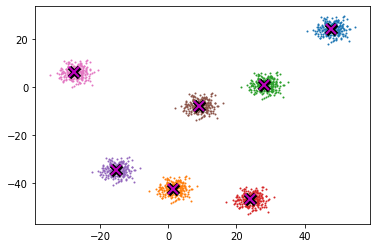

In [39]:
plot_data(centroids, data, n_samples)

We can also plot the data along the central point which has equal distance to each point in the data.

In [11]:
midp = data.mean(axis=0)
midp

DeviceArray([  9.896, -14.421], dtype=float32)

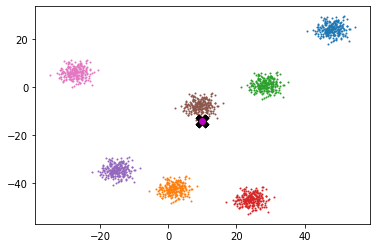

In [12]:
plot_data([midp]*n_clusters, data, n_samples)

## Mean shift

Mean shift is a less known clustering algorithm that has some interesting advantages compared to the more popular **k-means** algorithm:
* Instead of requiring the exact number of clusters ahead of time, it requires a **bandwidth** to be specified, which can be easily chosen automatically
* Out of the box is able to handle clusters of any shape (e.g. circles or moon shapes like below), whereas k-means (without using special extensions) can properly handle only clusters of a ball shape.

In [228]:
from sklearn.datasets import make_circles, make_moons

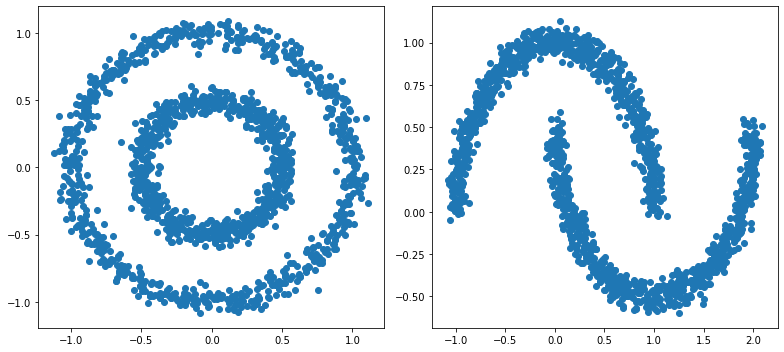

In [235]:
# Cricles
X1 = make_circles(factor=0.5, noise=0.05, n_samples=1500)

# Moons
X2 = make_moons(n_samples=1500, noise=0.05)

fig, ax = plt.subplots(1, 2)
for i, X in enumerate([X1, X2]):
    fig.set_size_inches(11, 5)
    ax[i].scatter(X[0][:, 0], X[0][:, 1])

plt.tight_layout();

### MeanShift components

The MeanShift clustering algorithm works as follows:
1. For each data point $x_i$ in the sample $X$, find the distance $d_{ij}$ between $x_i$ and every other point $x_j$ in $X$. i.e. $d_{ij} = \| x_i - x_j \|$
1. Calculate weights $w_{ij}$ for each point $x_i$ in $X$ by applying the **Gaussian kernel** (with standard deviation set to **bandwidth**) to that point's distance to $x_j$.
1. Update x as the weighted average of all other points in X, weighted based on the previous step

The algorithm converge iteratively by pushing closer points even closer until they are next to each other.

Note:
* This weighting approach penalizes points further away from each other
* The rate at which the weights fall to zero is determined by the **bandwidth**.
* The value of **bandwidth** should be choosen so that it covers one third of the data.

#### Distance
The first component of MeanShift is the distance function, which is simply the Euclidean distance (also known as Norm 2 distance) and defined as follows: $ d\left( x_i, x_j \right)   = \sqrt {\sum _{k=1}^{K}  \left( x_{ik}-x_{jk}\right)^2 } $ 
where $x_i$ and $x_j$ are two observation arrays of dimension $K$.

The rest of this section implments the Norm2 distance in JAX.

In [73]:
X = data.clone()
x0 = data[0]

x0.shape, X.shape

((2,), (1750, 2))

In [22]:
X[None].shape, X[:, None].shape, (X[None]-X[:, None]).shape

((1, 1750, 2), (1750, 1, 2), (1750, 1750, 2))

In [23]:
dist = jnp.sqrt(((X[None]-X[:, None])**2).sum(axis=1))
dist.shape

(1750, 2)

In [130]:
def distance(X, x):
    diff = (X - x) if len(x.shape) == 1 else (X[None]-x[:, None])
    return jnp.sqrt((diff**2).sum(axis=-1))

In [131]:
X[2].shape, X[:2].shape, X[:2][:, None].shape

((2,), (2, 2), (2, 1, 2))

In [132]:
distance(X, X).shape, distance(X, X[:10]).shape, distance(X, X[0]).shape

((1750, 1750), (10, 1750), (1750,))

#### Gaussian kernel

MeanShift uses the Gaussian kernel to calculate the weights by applying it to the distance between $x_i$ and $x_j$ as follows $w_{ij} = \varphi(\| x_i - x_j \|)$. It is defined by the following equation:

$$\varphi(z) = \frac{1}{\sigma*\sqrt{2\pi}}e^{\frac{-z^2}{2*\sigma^2}}$$ 

> Note: $\sigma$ is the standard deviation, and $\mu$ (i.e. the mean) is 0

In JAX, it is implemented as follows:

In [13]:
def gaussian(x, bandwidth, mean=0):
    return jnp.exp(-0.5 * ((x-mean)/bandwidth)**2) / (bandwidth*jnp.sqrt(2*math.pi))

Let's plot the above function to have a better sence of how its output looks like

In [14]:
def plot_func(f):
    x=jnp.linspace(0, 10, 100)
    plt.plot(x, f(x))

With a bandwidth of value 2.5 we get the following plot.


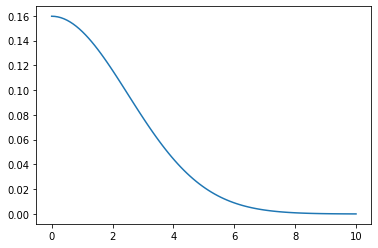

In [15]:
plot_func(partial(gaussian, bandwidth=2.5))

Notice how the output of the gaussion follows a decreasing line then literally becomes 0 for input greater or equal to 8. In fact, we can approximate this Gaussion with a much faster to calculate function defined as follows:


In [16]:
def tri(x, i):
    return (-x + i).clip(0)/i

You can see from the plot that the output looks very similar to a gaussian.

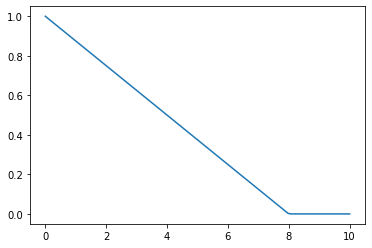

In [17]:
plot_func(partial(tri, i=8))

Before going further let's try the gaussian on some inputs for validation

In [194]:
dist_0 = jnp.sqrt(((x0-X)**2).sum(axis=1))
dist_0.shape, dist_0

((1750,),
 DeviceArray([ 0.   ,  3.869,  5.187, ..., 81.709, 76.189, 83.284], dtype=float32))

In [195]:
weight_0 = gaussian(dist_0, 2.5)
weight_0.shape, weight_0

((1750,),
 DeviceArray([0.16 , 0.048, 0.019, ..., 0.   , 0.   , 0.   ], dtype=float32))

In [21]:
weight_0[:,None] * X

DeviceArray([[ 7.814,  4.246],
             [ 2.522,  1.374],
             [ 0.812,  0.485],
             ...,
             [-0.   , -0.   ],
             [-0.   ,  0.   ],
             [-0.   ,  0.   ]], dtype=float32)

#### Calculating the weights

Now we can finally claculate the weights

In [133]:
weight = gaussian(distance(X, X[:10]), 2)

In [134]:
weight_tri = tri(distance(X, X[:10]), 8)

In [135]:
weight.shape, weight_tri.shape, X.shape

((10, 1750), (10, 1750), (1750, 2))

The weight matrix is used in the Mean Shift algorithm to normalize X as follows:

In [192]:
num = jnp.dot(weight, X)
div = weight.sum(-1, keepdims=True)
X_out = num/div

In [193]:
num.shape, div.shape, X_out.shape, X_out

((10, 2), (10, 1), (10, 2), DeviceArray([[48.542, 25.583],
              [50.357, 26.867],
              [45.713, 25.075],
              ...,
              [47.695, 24.937],
              [47.378, 23.747],
              [47.36 , 22.198]], dtype=float32))

In [159]:
weight.shape, weight.sum(axis=1).shape

((10, 1750), (10,))

#### Putting everything together

After defining all the components, the following method group them to apply one step of the Mean Shift algorithm on a batch of oberservations

In [165]:
def batched_meanshift_fn(X, bw=2):
  @jax.jit
  def apply(Xb):
    wb = gaussian(distance(X, Xb), bw)
    Xb_out = jnp.dot(wb, X) / wb.sum(-1, keepdims=True)
    return Xb_out
  return apply

For reference this is the expected shape of each of the vectors that the above function manipulate:

|array|shape|
|-|-|
|`X`|`(N, 2)`|
|`Xb`|`(batch_size, 2)`|
|`wb`|`(batch_size, N)`|
|`Xb_out`|`(batch_size, 2)`|

In [208]:
func = batched_meanshift_fn(X, 2)
func(X[:10])

DeviceArray([[48.542, 25.583],
             [50.357, 26.867],
             [45.713, 25.075],
             ...,
             [47.695, 24.937],
             [47.378, 23.747],
             [47.36 , 22.198]], dtype=float32)

In [209]:
func = batched_meanshift_fn(X, 2)
func(X[0])

((2,), DeviceArray([48.542, 25.583], dtype=float32))

### Manually batching the data

Even if it is slower, we should first try the algorithm on manually batched data to check that the final result matches the expectations

In [215]:
def meanshift_step_1(step, args):
    X, bs, bw = args
    n = X.shape[0]
    batches = []
    batch_apply = batched_meanshift_fn(X, bw)
    for i in range(0, n, bs):
        s = slice(i, min(i+bs, n))
        Xb = batch_apply(X[s])
        batches.append(Xb)
    X_out = jnp.concatenate(batches, axis=0)
    return (X_out, bs, bw)

def meanshift_1(data, bs=500, bw=2, steps=5):
    X = data.clone()
    Xs = [X]
    for i in range(steps):
        X, _, _ = meanshift_step_1(i, (X, bs, bw))
        Xs.append(X)
    return X, Xs

Check how long it takes to run this implementation using the default batch size of 500.

In [214]:
%%time
X_out, _ = meanshift_1(data)

CPU times: user 1.07 s, sys: 10.2 ms, total: 1.08 s
Wall time: 895 ms


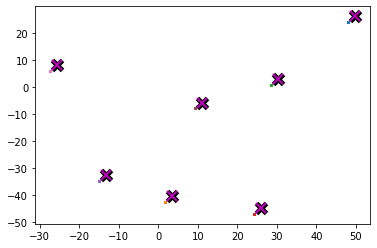

In [200]:
plot_data(centroids+3, X_out, n_samples)

The implementation is slower when using fews observations by batch. It is the worst when using the lowest batch size of 1.

In [201]:
%%time
X_out, _ = meanshift_1(data, 1)

CPU times: user 5.12 s, sys: 159 µs, total: 5.12 s
Wall time: 5.12 s


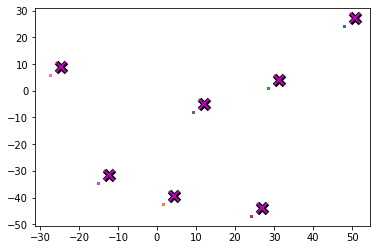

In [206]:
plot_data(centroids+3, X_out, n_samples)

Increasing the batch size, the algorithm finishes earlier.

In [203]:
%%time
X_out, _ = meanshift_1(data, 1000)

CPU times: user 1.04 s, sys: 12.2 ms, total: 1.05 s
Wall time: 884 ms


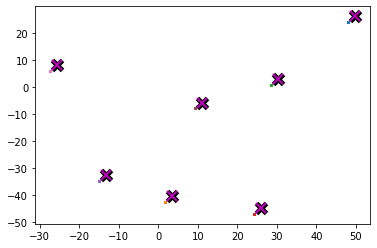

In [204]:
plot_data(centroids+3, X_out, n_samples)

### Auto-vectorization with vmap

We can mush faster when using JAX vectorizing map [vmap](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html#jax.vmap). This will allow us to run a function on each element of the array in parallel.

In [189]:
def meanshift_step_2(step, args):
    X, bw = args
    func = batched_meanshift_fn(X, bw)
    X_out = jax.vmap(func)(X)
    return (X_out, bw)

def meanshift_2(data, bw=2, steps=5):
    X = data.clone()
    X, _ = jax.lax.fori_loop(0, steps, meanshift_step_2, (X, bw))
    return X

In [211]:
%%time
X_out = meanshift_2(data, n_clusters*n_samples)

CPU times: user 406 ms, sys: 0 ns, total: 406 ms
Wall time: 223 ms


> Warning: we are using JAX with a CPU backend, hence it took our implementation that much of time to finish. We could benefit of vmap a lot more when using JAX with a GPU or TPU backend.

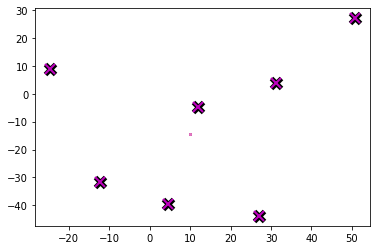

In [212]:
plot_data(centroids+3, X_out, n_samples)

### MeanShift steps animated

Because Mean Shift is an iterative algorithm, we can visualize how the clusters change on every step.

In [217]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [218]:
_, Xs = meanshift_1(data, 500)

In [219]:
def do_one(d):
    X = Xs[d]
    ax.clear()
    plot_data(centroids+3, X, n_samples, ax=ax)

In [220]:
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

## That's all folks

We have seen that MeanShift can be easily implemented in JAX. Similarly we could easily implement with JAX any of the other clustering algorithms: k-means clustering, dbscan, locality sensitive hashing.

I hope you enjoyed this article, feel free to leave a comment or reach out on twitter [@bachiirc](https://twitter.com/bachiirc).